<a href="https://colab.research.google.com/github/unjike/Modeling-and-Simulation-of-Advanced-Manufacturing-Processes/blob/main/Modeling_and_Simulation_of_Laser_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Importing usefull libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
 
##initializing constants
K = 135 # W/(mK)                           <---          Thermal conductivity (isotropic)
rho_o = 6500   # kg/m3                     <---          Density
C = 450 # J/kgK                            <---          Heat Capacity

theta_o = 300 # K                          <---          Initial temperature
theta_w = 300 # K                          <---          Wall temperature
I_o = 2*10**8 # W/m^2                        <---          Initial Laser Intensity

a = 25 # m^-1                              <---          absorption constant
t_f = 2 # s                                <---          Final time of simulation
dt = 10**-3 # s                            <---          Time step

#iniializing time
t=np.arange(0,t_f+dt, dt)

# defining a function for a transient temperature distribution

def trnstempdist(n):
  '''
  This function returns a transient temperature distribution for a given number of node
  '''
  # initializing temperature
  theta = [theta_o*np.ones(n*n*n)]

  # initializing nodes
  x = np.linspace(0,0.05,n)

  # initializing node spacing
  dx = np.copy(x[1])

  # initializing matrix multiplier
  A = -6*np.identity(n*n*n) + np.eye(n*n*n, k=-1) + np.eye(n*n*n, k=1) + np.eye(n*n*n, k=-n) + np.eye(n*n*n, k=n) + np.eye(n*n*n, k=n*n) + np.eye(n*n*n, k=-n*n)

  # selecting top and bottom walls
  top_and_bottom_walls = [*range(n*n),*range(-n*n,0)]

  # selecting side walls list
  side_walls = []

  # from facing wall
  for i in range(1,20):
    for j in range(i*n*n, i*n*n+n):
      side_walls.append(j)

  # back facing wall
  for i in range(1,20):
    for j in range((i+1)*n*n-n, (i+1)*n*n):
      side_walls.append(j)

  # left side facing wall
  for i in range(1,20):
    for j in 21*np.arange(1, 20):
      side_walls.append(i*n*n+j)

  # right side facing wall
  for i in range(1,20):
    for j in 21*np.arange(1, 20):
      side_walls.append(i*n*n+20+j)
    
  all_walls = side_walls + top_and_bottom_walls

  # Assigning zeros to the walls to ensure no chage in temperature
  for i in all_walls:
    A[i] = np.zeros(n*n*n)

  # converting to a sparse A matrix
  A_sparse = csr_matrix(A)

  # initializing the laser
  I_index = []
  z = []
  # selecting lazer zone
  for i in range (21):
    for j in range(8,12):
      #selecting indexes where the lazer is applied and calculating the z distance from the top
      I_index = [*I_index,*np.arange(i*n*n+j*n+8,i*n*n+j*n+12)]
      z = [*z,*np.arange(i*n*n+j*n+8,i*n*n+j*n+12)//441]

  I_abs = np.zeros(n*n*n)

  iter = 0
  for i in I_index:
    I_abs[i] = a*I_o*np.exp(-a*(20/400 - z[iter]/400))
    iter+=1

  # converting to numpy array
  I_abs = np.array(I_abs)

  
  # transient temperature
  for i in range(len(t)-1):
    theta.append(theta[i] + dt*K/(rho_o*C*dx**2)*A_sparse@theta[i] + dt/(rho_o*C)*I_abs)

    #adding insulation effect on the top surface
    for j in range(n*n):
      theta[-1][j] = theta[-1][j+n*n]
    #adding insulation effect on the bottom surface
    for k in range(-n*n,0):
      theta[-1][k] = theta[-1][k-n*n]

  return theta

In [14]:
n=21
theta = trnstempdist(n)
# theta[500][-441:].reshape((21, 21))

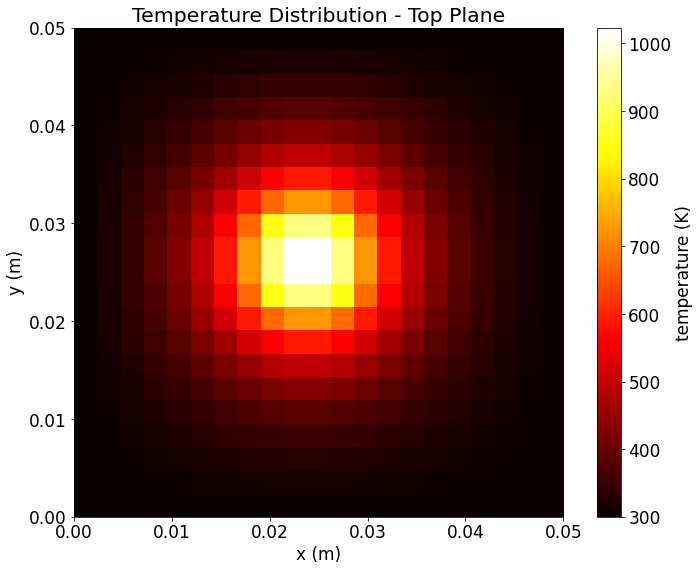

In [27]:
# plotting top surface
plt.rcParams.update({'font.size': 17, "figure.figsize":(12,9)})
plt.imshow(theta[-1][-441:].reshape((21, 21)), cmap='hot', extent=[0, 0.05, 0 , 0.05])
plt.colorbar(label = 'temperature (K)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Temperature Distribution - Top Plane')

plt.show()

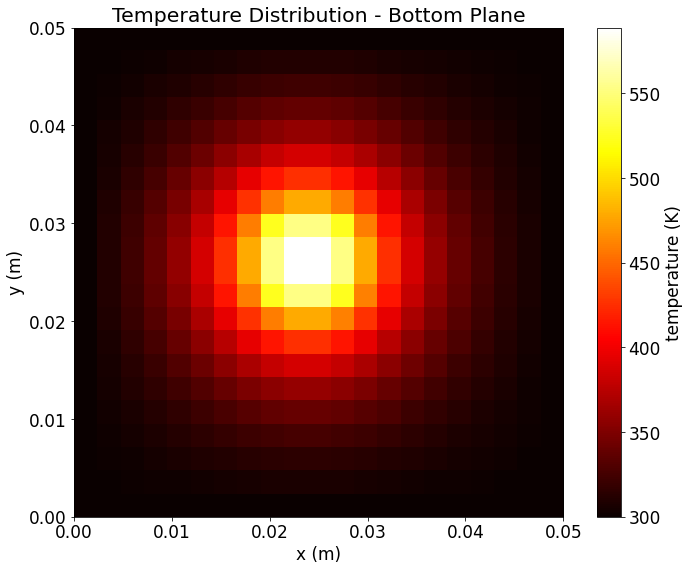

In [28]:
# Plotting bottom surface
plt.imshow(theta[-1][:441].reshape((21, 21)), cmap='hot', extent=[0, 0.05, 0 , 0.05])
plt.colorbar(label = 'temperature (K)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Temperature Distribution - Bottom Plane')
plt.show()